In [3]:
%%capture --no-stderr
%pip install -U langgraph langsmith

# Used for this tutorial; not a requirement for LangGraph
%pip install -U langchain_anthropic

In [4]:
import getpass
import os

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("ANTHROPIC_API_KEY")

In [5]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "LangGraph Tutorial"

In [9]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")

class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-haiku-20240307")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile(checkpointer=memory)

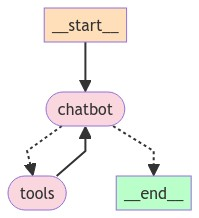

In [10]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

In [11]:
config = {"configurable": {"thread_id": "1"}}

In [12]:
user_input = "Hi there! My name is Rahil."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Rahil.
================================== Ai Message ==================================

It's nice to meet you, Rahil! I'm an AI assistant created by Anthropic. I'm here to help you with any questions or tasks you may have. Please let me know how I can assist you.


In [13]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Absolutely, I'll remember your name is Rahil. It's a pleasure to meet you! Please feel free to let me know if you have any questions or if there is anything I can assist you with.


In [14]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Rahil.', id='d7113c97-813b-47a0-83db-4a8edfcac1dd'), AIMessage(content="It's nice to meet you, Rahil! I'm an AI assistant created by Anthropic. I'm here to help you with any questions or tasks you may have. Please let me know how I can assist you.", response_metadata={'id': 'msg_01MWnTcgQV8dKUGMQ1iq5BPy', 'model': 'claude-3-haiku-20240307', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 377, 'output_tokens': 50}}, id='run-ad65c392-7809-4257-9e3c-4fafd10a86ba-0'), HumanMessage(content='Remember my name?', id='96f80f81-df6d-4828-92ec-3072488da589'), AIMessage(content="Absolutely, I'll remember your name is Rahil. It's a pleasure to meet you! Please feel free to let me know if you have any questions or if there is anything I can assist you with.", response_metadata={'id': 'msg_01NxVf9QC8SPdTwH4t2MGkNs', 'model': 'claude-3-haiku-20240307', 'stop_reason': 'end_turn', 'stop_sequence': N

In [7]:
from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)

--- Logging error ---
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/langchain_core/callbacks/manager.py", line 1997, in _configure
    handler = LangChainTracer(
              ^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/langchain_core/tracers/langchain.py", line 91, in __init__
    self.client = client or get_client()
                            ^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/langchain_core/tracers/langchain.py", line 54, in get_client
    _CLIENT = Client()
              ^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/langsmith/client.py", line 534, in __init__
    _validate_api_key_if_hosted(self.api_url, self.api_key)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/langsmith/client.py", line

Assistant: [{'id': 'toolu_017GxJQUsne5nmuGtDnxL7cC', 'input': {'query': 'latest in indian politics'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]


--- Logging error ---
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/langchain_core/callbacks/manager.py", line 1997, in _configure
    handler = LangChainTracer(
              ^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/langchain_core/tracers/langchain.py", line 91, in __init__
    self.client = client or get_client()
                            ^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/langchain_core/tracers/langchain.py", line 54, in get_client
    _CLIENT = Client()
              ^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/langsmith/client.py", line 534, in __init__
    _validate_api_key_if_hosted(self.api_url, self.api_key)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/langsmith/client.py", line

Assistant: [{"url": "https://indianexpress.com/section/political-pulse/", "content": "Among 33 suspended Lok Sabha MPs, 3 Congress MPs\nwhose cases were referred to Privileges panel\nAbdul Khaleque, K Jeyakumar and Vijay Vasanth, who had climbed on to Speaker\u2019s podium to raise slogans, were suspended pending report of Privileges Committee\nPeople\u2019s voice choked, super autocracy, why is BJP afraid, asks Mamata\nOn eve of INDIA meeting, says bloc need not project a Prime Ministerial candidate\nGaurav Gogoi on suspension of MPs: \u2018This blemish on Home Minister\u2019s record (LS breach) cannot be washed away by his silence\u2019\n\u201cProceedings right now, it seems, are directly controlled by PMO \u2026 The Home Minister is the one who is taking most of the decisions,\u201d says Congress\u2019s Deputy Leader in Lok Sabha\nWhen LS saw highest suspension in a day: 63 MPs faced action in March 1989 over Thakkar panel reportPremium Story\n63 Oppn MPs were suspended during Rajiv

--- Logging error ---
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/langchain_core/callbacks/manager.py", line 1997, in _configure
    handler = LangChainTracer(
              ^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/langchain_core/tracers/langchain.py", line 91, in __init__
    self.client = client or get_client()
                            ^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/langchain_core/tracers/langchain.py", line 54, in get_client
    _CLIENT = Client()
              ^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/langsmith/client.py", line 534, in __init__
    _validate_api_key_if_hosted(self.api_url, self.api_key)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/langsmith/client.py", line

Assistant: The key updates from the latest developments in Indian politics based on the search results include:

- 33 opposition Lok Sabha MPs have been suspended pending a report from the Privileges Committee, with 3 Congress MPs among them. The opposition has accused the government of behaving in a "super autocratic" manner and trying to bulldoze legislation in an "opposition-less" Parliament.

- The opposition INDIA alliance is set to meet today to discuss issues like seat sharing and redrawing their strategy to counter the ruling BJP. The alliance is also likely to discuss the caste census issue.

- There is ongoing tension between the new Congress leadership in Madhya Pradesh and the previous Kamal Nath-era leadership. The party faces challenges in Uttar Pradesh as well, with Rahul and Priyanka Gandhi fighting shy of taking a lead role.

- The current suspension of MPs is part of a long history of such actions in Indian Parliament, with the first MP being suspended in 1959.

- The